Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [153]:
import logging
from itertools import combinations
import itertools
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx

from icecream import ic
import networkx as nx
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.DEBUG)

In [1]:
#CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])

DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head(len(CITIES))

NameError: name 'pd' is not defined

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [155]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1] #ending point=starting point => cicle
    assert set(tsp) == set(range(len(CITIES))) #check that all the cities are visited

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

In [156]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    logging.debug(
        f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
    )
    visited[closest] = True
    city = closest
    tsp.append(int(city))
logging.debug(
    f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
)
tsp.append(tsp[0])


logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")

DEBUG:root:step: Isangel -> Vila (223.00km)
DEBUG:root:step: Vila -> Lakatoro (206.74km)
DEBUG:root:step: Lakatoro -> Norsup (2.46km)
DEBUG:root:step: Norsup -> Luganville (67.09km)
DEBUG:root:step: Luganville -> Port Olry (52.02km)
DEBUG:root:step: Port Olry -> Longana (105.77km)
DEBUG:root:step: Longana -> Sola (165.49km)
DEBUG:root:step: Sola -> Isangel (652.96km)
INFO:root:result: Found a path of 8 steps, total length 1475.53km


## Second Greedy Algorithm

In [157]:
"""Verifica se aggiungendo un segmento a `edges` si forma un ciclo"""
def cyclic(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False

In [158]:
logging.debug(
        f"step: {CITIES.at[6,'name']} -> {CITIES.at[1,'name']} ({DIST_MATRIX[6,1]:.2f}km)"
    )

DEBUG:root:step: Sola -> Lakatoro (246.17km)


In [159]:
# Funzione per aggiungere un segmento
def add_segment(segments, cities, distance):
    city1, city2 = cities
    # Aggiungi city1 a segments
    if city1 not in segments:
        segments[city1] = {}
    # Aggiungi city2 a segments
    if city2 not in segments:
        segments[city2] = {}
    
    # Aggiungi la distanza tra city1 e city2
    segments[city1][city2] = distance
    segments[city2][city1] = distance  # Aggiungi la distanza anche in senso inverso

In [160]:
def generate_pair_permutations(nodes):
    # Genera tutte le permutazioni di coppie
    pair_permutations = list(itertools.permutations(nodes, 2))
    return pair_permutations

In [161]:
# Creazione dei segmenti possibili tra le città con le rispettive distanze
segments = [
    ({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)
]

segments = sorted(segments, key=lambda e: e[1])  # Ordina i segmenti per distanza
shortest_cities=set()


visited = set()
edges = set()

count=0
# Selezione greedy dei segmenti
while len(visited) < len(CITIES):
    # Seleziona il segmento più corto che non forma un ciclo e non è già visitato
    shortest = next(
        s for s in segments 
        if not cyclic(edges | {tuple(s[0])}) and not (s[0].issubset(visited))
    )
    
    # Aggiorna visited ed edges
    visited |= shortest[0]
    edges.add(tuple(shortest[0]))

    city1, city2 = tuple(shortest[0])
    
    # Stampa il tratto del percorso
    logging.debug(f"Step: {CITIES.at[city1, 'name']} -> {CITIES.at[city2, 'name']} ({shortest[1]:.2f} km)")
    shortest_cities.add((frozenset(shortest[0]), shortest[1]))

    # Rimuove i segmenti che formerebbero un ciclo con i nuovi edges
    segments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]


print("----------")
print(len(shortest))
print("----------")




DEBUG:root:Step: Lakatoro -> Norsup (2.46 km)
DEBUG:root:Step: Luganville -> Port Olry (52.02 km)
DEBUG:root:Step: Longana -> Luganville (94.16 km)
DEBUG:root:Step: Port Olry -> Sola (141.25 km)
DEBUG:root:Step: Lakatoro -> Vila (206.74 km)
DEBUG:root:Step: Isangel -> Vila (223.00 km)


----------
2
----------


In [162]:
cities={}
for s in shortest_cities:
    city1,city2=s[0]
    #print(city1, city2)
    distance= s[1]
    add_segment(cities, (city1, city2), distance)
print(cities)

{0: {7: 223.00475078893413}, 7: {0: 223.00475078893413, 1: 206.73999705909532}, 3: {5: 52.02059578889833, 2: 94.15587871722444}, 5: {3: 52.02059578889833, 6: 141.25045822137164}, 2: {3: 94.15587871722444}, 1: {4: 2.458237855964039, 7: 206.73999705909532}, 4: {1: 2.458237855964039}, 6: {5: 141.25045822137164}}


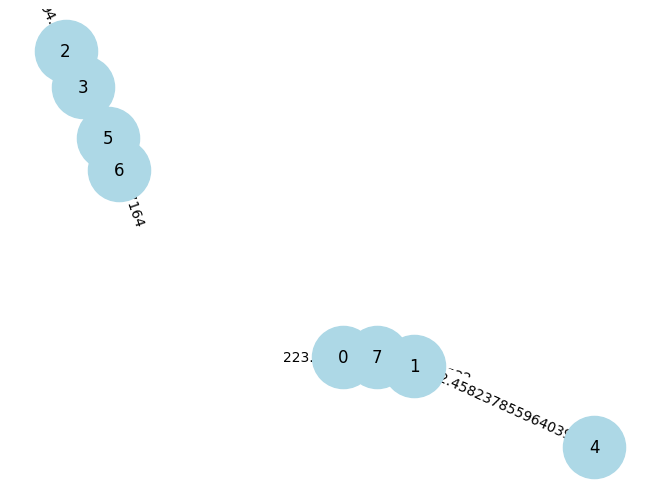

In [163]:
G = nx.Graph()

# Aggiunta dei segmenti
for start, ends in cities.items():
    for end, distance in ends.items():
        G.add_edge(start, end, weight=distance)

# Visualizzazione del grafo
pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()



In [164]:
def find_min_distance_pairs(nodes):
    pair_permutations = generate_pair_permutations(nodes)
    min_pairs = []
    used_nodes = set()  # Per tenere traccia dei nodi già uniti

    for pair in pair_permutations:
        if pair[0] not in used_nodes and pair[1] not in used_nodes:
            # Trova l'indice dei nodi
            index1, index2 = pair
            print(index1, index2)
            #index2 = pair[1]
            distance = DIST_MATRIX[index1][index2]
            min_pairs.append((pair, distance))

    # Trova la coppia con la minima distanza
    min_pairs.sort(key=lambda x: x[1])  # Ordina per distanza
    return min_pairs

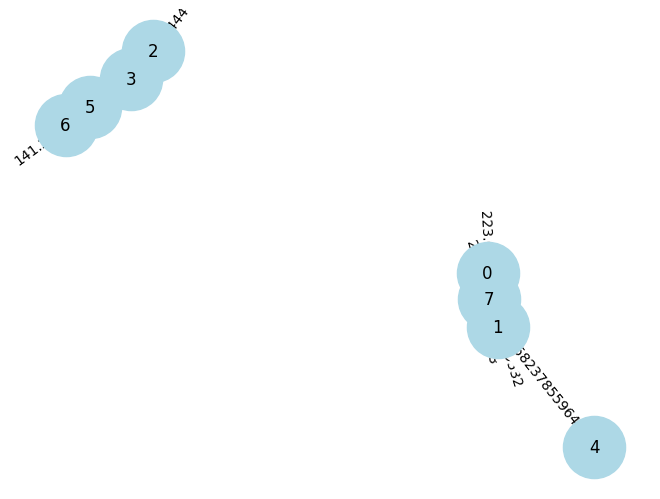

Il grafo non è ciclico.


In [165]:

# Dati delle distanze tra le città (matrice delle distanze)

# Creazione del grafo
G = nx.Graph()

# Aggiunta dei segmenti al grafo

# Aggiunta degli archi al grafo
for start, ends in cities.items():
    for end, distance in ends.items():
        G.add_edge(start, end, weight=distance)

pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

# Funzione per verificare se il grafo è ciclico
def is_cyclic(graph):
    return nx.is_connected(graph) and any(nx.simple_cycles(graph))

# Controlla se il grafo è ciclico
if is_cyclic(G):
    print("Il grafo è ciclico.")
else:
    print("Il grafo non è ciclico.")

    # Trova gli archi staccati
    disconnected_edges = []
    
    for node in G.nodes:
        if G.degree(node) == 1:
            disconnected_edges.append(node)
            # Trova il vicino



In [166]:
def find_connected_components(graph):
    # Trova i gruppi di nodi connessi
    return list(nx.connected_components(graph))

# Identifica i gruppi
connected_components = find_connected_components(G)

list_group=[]
# Stampa i gruppi
print("Gruppi di nodi connessi nel grafo:")
for i, component in enumerate(connected_components, 1):
    list_group.append(component)
    print(f"Gruppo {i}: {component}")





Gruppi di nodi connessi nel grafo:
Gruppo 1: {0, 1, 4, 7}
Gruppo 2: {2, 3, 5, 6}


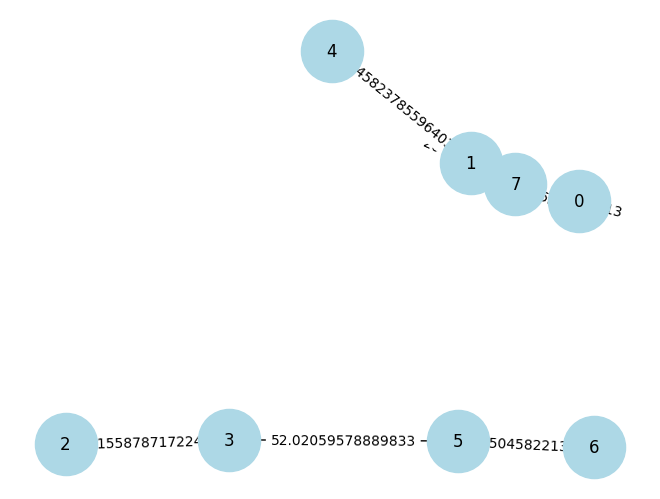

[(0, 2)]
Connessioni possibili per formare un ciclo:
Nodo 0 da Gruppo 1 può connettersi a Nodo 2 da Gruppo 2
Nodo 0 da Gruppo 1 può connettersi a Nodo 6 da Gruppo 2
Nodo 4 da Gruppo 1 può connettersi a Nodo 2 da Gruppo 2
Nodo 4 da Gruppo 1 può connettersi a Nodo 6 da Gruppo 2
Nodo 2 da Gruppo 2 può connettersi a Nodo 0 da Gruppo 1
Nodo 2 da Gruppo 2 può connettersi a Nodo 4 da Gruppo 1
Nodo 6 da Gruppo 2 può connettersi a Nodo 0 da Gruppo 1
Nodo 6 da Gruppo 2 può connettersi a Nodo 4 da Gruppo 1


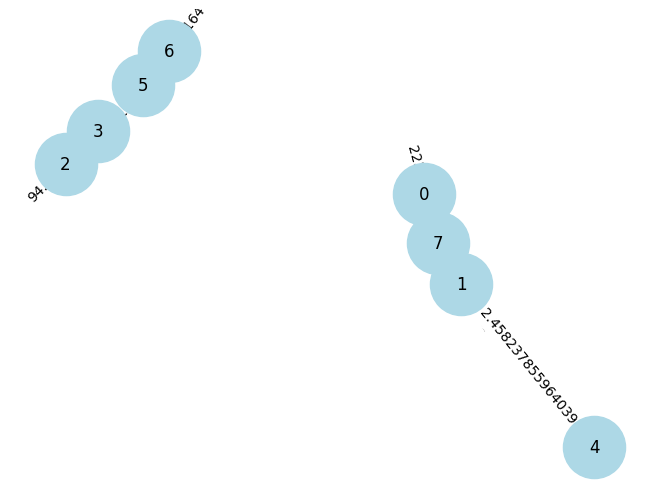


Archi del ciclo creato:
(0, 2)
Il grafo non è ciclico.


In [167]:
pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

# Funzione per identificare le connessioni possibili tra i gruppi
def identify_cycle_connections(groups):
    connections = []  # Lista delle connessioni possibili

    # Condizione di connessione: se la somma di due nodi è un certo valore (es. 6)
    for i in range(len(groups)):
        for j in range(len(groups)):
            if i != j:  # Non confrontare lo stesso gruppo
                for node1 in groups[i]:
                    for node2 in groups[j]:
                         # Controlla se entrambi i nodi hanno solo 1 arco
                        if G.degree(node1) == 1 and G.degree(node2) == 1:
                            connections.append((node1, node2, i, j))

    return connections

# Funzione per creare un ciclo
def create_cycle(groups, connections):
    cycle_edges = []
    used_groups = set()  # Per tenere traccia dei gruppi già utilizzati

    # Iniziamo da un gruppo e proviamo a formare il ciclo
    current_group = 0  # Iniziamo dal primo gruppo
    while len(used_groups) < len(groups):
        if current_group not in used_groups:
            used_groups.add(current_group)
            # Trova le connessioni da questo gruppo
            for connection in connections:
                node1, node2, group1_idx, group2_idx = connection
                if group1_idx == current_group and group2_idx not in used_groups:
                    cycle_edges.append((node1, node2))
                    current_group = group2_idx  # Passa al prossimo gruppo
                    break
            else:
                break  # Se non ci sono più connessioni, termina il ciclo
        else:
            current_group += 1  # Passa al gruppo successivo

    return cycle_edges

# Identifica le connessioni
connections = identify_cycle_connections(list_group)

# Crea un ciclo
cycle_edges = create_cycle(list_group, connections)

print(cycle_edges)
# Stampa le connessioni e gli archi del ciclo
print("Connessioni possibili per formare un ciclo:")
for connection in connections:
    node1, node2, group1_idx, group2_idx = connection
    print(f"Nodo {node1} da Gruppo {group1_idx + 1} può connettersi a Nodo {node2} da Gruppo {group2_idx + 1}")

pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

print("\nArchi del ciclo creato:")
for edge in cycle_edges:
    G.add_edge(edge[0], edge[1])
    print(edge)

# Controlla se il grafo è ciclico
if is_cyclic(G):
    print("Il grafo è ciclico.")
else:
    print("Il grafo non è ciclico.")

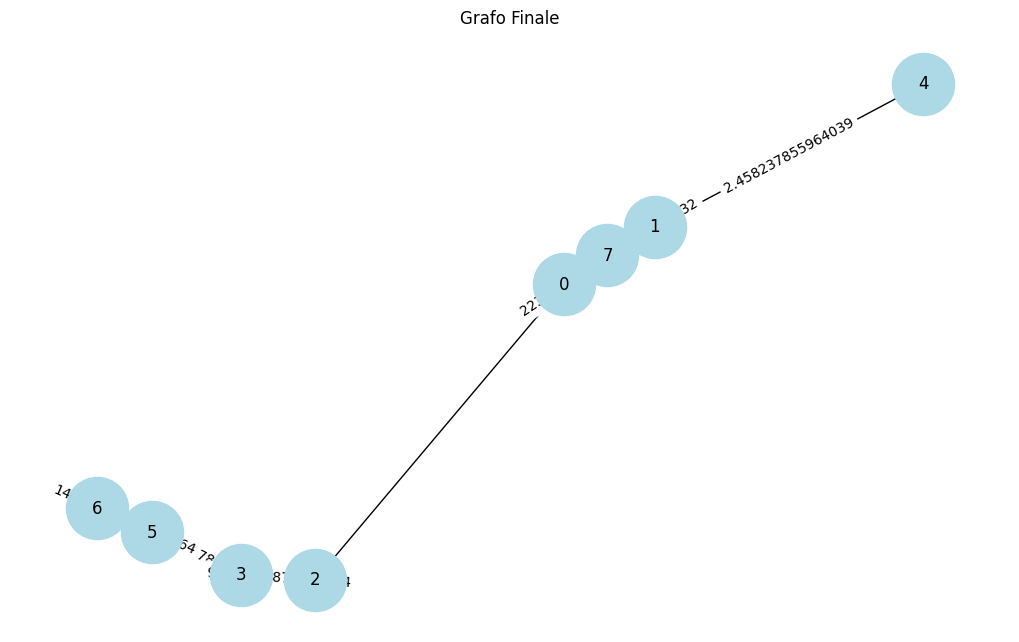

In [168]:
# Visualizzazione del grafo
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Grafo Finale")
plt.show()

In [169]:
'''# Stampa finale delle città visitate e dei segmenti selezionati
logging.info("Città visitate: " + ", ".join([CITIES.at[city, 'name'] for city in visited]))

# Creazione del percorso completo per tornare alla città di partenza
start_city = next(iter(visited))  # Prendi una città di partenza
complete_path = [start_city]

# Aggiungi le città visitate nel percorso
for city1, city2 in edges:
    if city1 not in complete_path:
        complete_path.append(city1)
    if city2 not in complete_path:
        complete_path.append(city2)

# Assicurati di tornare alla città di partenza
if complete_path[-1] != start_city:
    complete_path.append(start_city)

# Calcola la lunghezza totale del percorso e stampa i tratti
total_distance = 0
for i in range(len(complete_path) - 1):
    distance = DIST_MATRIX[complete_path[i], complete_path[i + 1]]
    total_distance += distance
    logging.info(f"{CITIES.at[complete_path[i], 'name']} -> {CITIES.at[complete_path[i + 1], 'name']} ({distance:.2f} km)")

# Stampa il percorso completo
logging.info(f"Percorso completo: {[CITIES.at[city, 'name'] for city in complete_path]}")
logging.info(f"Risultato: Trovato un percorso di {len(complete_path) - 1} tratti, lunghezza totale {total_distance:.2f} km")'''

'''shortest = next(_ for _ in sorted(segments, key=lambda e: e[1]))
visited |= shortest[0]
visited
edges |= {tuple(shortest[0])}
segments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]
segments
cyclic(edges)'''


'shortest = next(_ for _ in sorted(segments, key=lambda e: e[1]))\nvisited |= shortest[0]\nvisited\nedges |= {tuple(shortest[0])}\nsegments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]\nsegments\ncyclic(edges)'

In [170]:
'''# Dati delle distanze tra le città
segments = {
    "Lakatoro": {"Norsup": 2.46, "Vila": 206.74},
    "Luganville": {"Port Olry": 52.02, "Longana": 94.16},
    "Longana": {"Luganville": 94.16},
    "Port Olry": {"Sola": 141.25},
    "Sola": {},
    "Vila": {"Isangel": 223.00},
    "Isangel": {"Vila": 223.00}
}

# Creazione del grafo
G = nx.Graph()

# Aggiunta dei segmenti al grafo
for start, ends in segments.items():
    for end, distance in ends.items():
        G.add_edge(start, end, weight=distance)

def find_shortest_circuit(graph, start_city):
    # Trova tutte le città nel grafo
    cities = list(graph.nodes())
    
    # Rimuovi la città di partenza dalla lista delle città
    cities.remove(start_city)

    # Trova tutte le permutazioni delle città rimanenti
    shortest_distance = float('inf')
    shortest_path = None
    
    for perm in permutations(cities):
        # Crea il percorso che inizia e finisce con la città di partenza
        current_path = [start_city] + list(perm) + [start_city]
        current_distance = 0
        
        # Calcola la distanza totale del percorso
        for i in range(len(current_path) - 1):
            if graph.has_edge(current_path[i], current_path[i + 1]):
                current_distance += graph[current_path[i]][current_path[i + 1]]['weight']
            else:
                current_distance = float('inf')  # Percorso non valido

        # Aggiorna il percorso più corto se necessario
        if current_distance < shortest_distance:
            shortest_distance = current_distance
            shortest_path = current_path

    return shortest_path, shortest_distance

# Esempio di utilizzo
start_city = "Lakatoro"  # Città di partenza
path, distance = find_shortest_circuit(G, start_city)

print("Percorso più corto che parte e torna a", start_city)
print(" -> ".join(path))
print("Distanza totale:", distance)

# Visualizzazione del grafo
pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()'''

'# Dati delle distanze tra le città\nsegments = {\n    "Lakatoro": {"Norsup": 2.46, "Vila": 206.74},\n    "Luganville": {"Port Olry": 52.02, "Longana": 94.16},\n    "Longana": {"Luganville": 94.16},\n    "Port Olry": {"Sola": 141.25},\n    "Sola": {},\n    "Vila": {"Isangel": 223.00},\n    "Isangel": {"Vila": 223.00}\n}\n\n# Creazione del grafo\nG = nx.Graph()\n\n# Aggiunta dei segmenti al grafo\nfor start, ends in segments.items():\n    for end, distance in ends.items():\n        G.add_edge(start, end, weight=distance)\n\ndef find_shortest_circuit(graph, start_city):\n    # Trova tutte le città nel grafo\n    cities = list(graph.nodes())\n    \n    # Rimuovi la città di partenza dalla lista delle città\n    cities.remove(start_city)\n\n    # Trova tutte le permutazioni delle città rimanenti\n    shortest_distance = float(\'inf\')\n    shortest_path = None\n    \n    for perm in permutations(cities):\n        # Crea il percorso che inizia e finisce con la città di partenza\n        cur